## Bid - Ask Spreads 

A market- based evaluation of any derivatives should yield sufficiently accurate values, yet a lot of the time the listed prices on the open market differ from what most traditional models would dictate. A lot of these differences come from nuances in market microstructure affect pricing in some respects. The market always has at least 2 quotes a *bid* and an *ask* at which market makers will be actively willing to buy and sell option contracts.

These contracts generally have a spread garnered to the relative tick listing limit of whatever the listing exchange is, and this a 1 cent accurate model is not really going to work for pricing. 

## The Implied Volatility Surface

Recall that the impled volatility of a call options with some market quote $C^*_0$ is the value $\sigma^{imp}$ that solves the implicit equation:

$$C^*_0 = C^{BSM} (S_0, K, T, r, \sigma^{imp})$$

For this formula, vega, the first derivative of the BSM function wrt volatility, would be strictly positive, implying that the price of the option only strictly increases when volatility increases. This also shows that there is a unique solution as a strictly positive and increasing first derivative implies a bijective relationship.

The following code solves this equation though a numerical method:

In [1]:
# Valuation of European Call Options in BSM Model
# and Numerical Derivation of Implied Volatility


from math import log, sqrt, exp
from scipy import stats
from scipy.optimize import fsolve
import datetime

class call_option(object):
    ''' Class for European call options in BSM Model.
    
    Attributes
    ==========
    S0 : float
        initial stock/index level
    K : float
        strike price
    t : datetime/Timestamp object
        pricing date
    M : datetime/Timestamp object
        maturity date
    r : float
        constant risk-free short rate
    sigma : float
        volatility factor in diffusion term
        
    Methods
    =======
    value : float
        return present value of call option
    vega : float
        return vega of call option
    imp_vol : float
        return implied volatility given option quote
    '''
    
    def __init__(self, S0, K, t, M, r, sigma):
        self.S0 = float(S0)
        self.K = K
        self.t = t
        self.M = M
        self.r = r
        self.sigma = sigma

    def update_ttm(self):
        ''' Updates time-to-maturity self.T. '''
        if self.t > self.M:
            raise ValueError("Pricing date later than maturity.")
        self.T = (self.M - self.t).days / 365.

    def d1(self):
        ''' Helper function. '''
        d1 = ((log(self.S0 / self.K)
            + (self.r + 0.5 * self.sigma ** 2) * self.T)
            / (self.sigma * sqrt(self.T)))
        return d1
        
    def value(self):
        ''' Return option value. '''
        self.update_ttm()
        d1 = self.d1()
        d2 = ((log(self.S0 / self.K)
            + (self.r - 0.5 * self.sigma ** 2) * self.T)
            / (self.sigma * sqrt(self.T)))
        value = (self.S0 * stats.norm.cdf(d1, 0.0, 1.0)
            - self.K * exp(-self.r * self.T) * stats.norm.cdf(d2, 0.0, 1.0))
        return value
        
    def vega(self):
        ''' Return Vega of option. '''
        self.update_ttm()
        d1 = self.d1()
        vega = self.S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(self.T)
        return vega

    def imp_vol(self, C0, sigma_est=0.2):
        ''' Return implied volatility given option price. '''
        # This generates a dummy option object w/ some sigma estimate
        option = call_option(self.S0, self.K, self.t, self.M,
                             self.r, sigma_est)
        option.update_ttm()
        #This is a function that shows the difference between cost given
        #current sigma vs the target cost
        def difference(sigma):
            #This updates the estimate to a new sigma
            option.sigma = sigma
            return option.value() - C0
        #Solver that finds the roots to a given function
        #In this case it will find when theo value = given value
        iv = fsolve(difference, sigma_est)[0]
        return iv

t = datetime.datetime(2019,1,1)
M = datetime.datetime(2020,1,1)
call = call_option(100, 120, t, M, 0.01, 0.2)
print(call.imp_vol(5, 0.1))

0.2801904349754664


Using this method we can generate a volatility surface, ie a three dimensional surface that shows implied volatility given different option strikes and different maturity dates on the same underlying asset.

Looking at the real world returns of call options on the EUROSTOXX 50 index, some stylized facts about the following will be observed:

   - **smiles**: implied volatilities exhibit a smile form, meaning for calls the OTM implied volatilities are going to be higher than the ATM ones, and then there may be another increase as it trends ITM. 
   - **term structure**: smiles are more pronouced for short-term options than for longer-term options; a phenomena sometimes called volatility term structure
   
   Observing the implied volatilities of the EURO STOXX Options Quotes:
   

        Date  Strike    Call   Maturity  Put
0 2014-09-30  1850.0  1373.6 2014-12-19  0.5
1 2014-09-30  1900.0  1323.7 2014-12-19  0.6
2 2014-09-30  1950.0  1273.8 2014-12-19  0.8
3 2014-09-30  2000.0  1223.9 2014-12-19  0.9
4 2014-09-30  2050.0  1174.1 2014-12-19  1.1


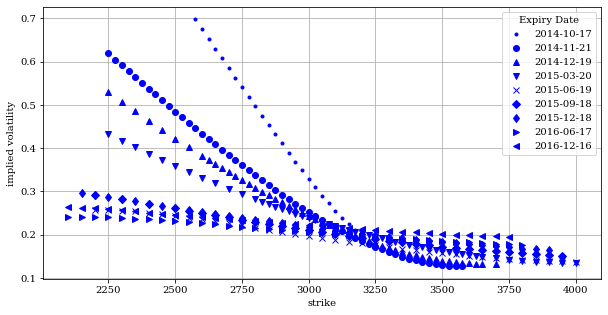

In [65]:
 # BSM Implied Volatilities of
# Call Options on the EURO STOXX 50
# Option Quotes from 30. September 2014


import numpy as np
import pandas as pd
from BSM_imp_vol import call_option
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
mpl.rcParams['font.family'] = 'serif'

# Pricing Data
pdate = pd.Timestamp('30-09-2014')

#
# EURO STOXX 50 index data
#

# URL of data file
es_url = 'http://www.stoxx.com/download/historical_values/hbrbcpe.txt'
# column names to be used
cols = ['Date', 'SX5P', 'SX5E', 'SXXP', 'SXXE',
        'SXXF', 'SXXA', 'DK5F', 'DKXF', 'DEL']
# reading the data with pandas
es = pd.read_csv(es_url,  # filename
                 header=None,  # ignore column names
                 index_col=0,  # index column (dates)
                 parse_dates=True,  # parse these dates
                 dayfirst=True,  # format of dates
                 skiprows=4,  # ignore these rows
                 sep=';',  # data separator
                 names=cols)  # use these column names
# deleting the helper column
del es['DEL']
S0 = es['SX5E']['30-09-2014']
r = -0.05

#
# Option Data
#
data = pd.HDFStore('es50_option_data.h5', 'r')['data']

#
# BSM Implied Volatilities
#


def calculate_imp_vols(data):
    ''' Calculate all implied volatilities for the European call options
    given the tolerance level for moneyness of the option.'''
    data['Imp_Vol'] = 0.0
    tol = 0.30  # tolerance for moneyness
    for row in data.index:
        t = data['Date'][row]
        T = data['Maturity'][row]
        ttm = (T - t).days / 365.
        forward = np.exp(r * ttm) * S0
        if (abs(data['Strike'][row] - forward) / forward) < tol:
            call = call_option(S0, data['Strike'][row], t, T, r, 0.2)
            data.loc[row, 'Imp_Vol'] = call.imp_vol(data.loc[row, 'Call'])
    return data


#
# Graphical Output
#
markers = ['.', 'o', '^', 'v', 'x', 'D', 'd', '>', '<']


def plot_imp_vols(data):
    ''' Plot the implied volatilites. '''
    maturities = sorted(set(data['Maturity']))
    plt.figure(figsize=(10, 5))
    for i, mat in enumerate(maturities):
        dat = data[(data['Maturity'] == mat) & (data['Imp_Vol'] > 0)]
        plt.plot(dat['Strike'].values, dat['Imp_Vol'].values,
                 'b%s' % markers[i], label=str(mat)[:10])
    plt.grid()
    plt.legend(title = 'Expiry Date')
    plt.xlabel('strike')
    plt.ylabel('implied volatility')

print(data.head())
imp_vols = calculate_imp_vols(data)
plot_imp_vols(imp_vols)

#Creating a 3D plot



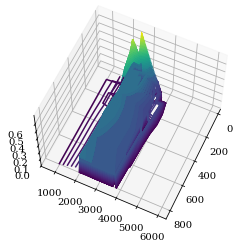

In [74]:

maturities = sorted(set(imp_vols['Maturity']))
strikes = imp_vols['Strike'].values
t = data['Date'].iloc[0]
ttm = [(T - t).days for T in maturities]
X, Y = np.meshgrid(ttm, strikes)

Z = np.zeros((len(strikes),len(maturities)), dtype = np.float64)
for j in range(len(maturities)):
    for i in range(len(strikes)):
        try:
            Z[i,j] = imp_vols[(imp_vols['Maturity'] == maturities[j]) & \
              (imp_vols.Strike == strikes[i])]['Imp_Vol']
        except:
            pass
    

fig2 = plt.figure()
ax = plt.axes(projection = '3d')
ax.contour3D(X, Y, Z, 50)
ax.view_init(60,25)


The script uses quote prices of the call options and their given maturities to show the implied volatility of the option at different strike prices across different maturities. As shown, shorter expiry options have a much steeper curve associated with them over closer to the money options.

